## Reading in the Featureset
- slightly pre-processed data exists from acquisition from stockpup  

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from sklearn.preprocessing import scale
from sklearn.svm import SVR
import tensorflow as tf 
import pickle

# For Visualization
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline

# matplotlib.style.use('ggplot')
df=pd.read_csv('features.csv')

print("Read in CSV")

Read in CSV


## Separating Out the Training and Test Sets
- training set is everything but the last 4 quarters of data for each company 
- test set is the last 4 quarters

In [2]:
# df.sort_values(by=['Id', 'Quarter end'], ascending=[1, 0])
ids = df.Id.unique()

# Seperate out the most recent quarter as it isn't yet labelled with next quarter's gain
first_indices = []
for stock_id in ids:
    temp = df.loc[df.Id==stock_id].sort_values(by=['Quarter end'], ascending=[0])
    first_indices.append(temp.index[0])

current_qdf = df.ix[first_indices].reset_index(drop=True) # Current Quarter Dataframe
past_qdf = df.drop(df.index[first_indices]).reset_index(drop=True)

# Separating out training and test indices
test_on = 16 # how many previous quarters to build the test off of
test_indices = []
to_drop = []
for stock_id in ids:
    temp = past_qdf.loc[past_qdf.Id==stock_id].sort_values(by=['Quarter end'], ascending=[0])
    # Remove elements that do not have atleast n number of points 
    if len(temp.index.values) < test_on: 
        for i in range(len(temp.index.values)):
            to_drop.append(temp.index[i])
    else:
        for i in range(test_on):
            try:
                test_indices.append(temp.index[i])
            except:
                pass # TODO Add Error Reporting

filtered = past_qdf#.drop(past_qdf.index[to_drop])
test_df = filtered.ix[test_indices].reset_index(drop=True)          
train_df = filtered.drop(filtered.index[test_indices]).reset_index(drop=True)
# print train_df[:10]
# Keeping only the numerical values from the data tables as features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
test_df = test_df.select_dtypes(include=numerics)
train_df = train_df.select_dtypes(include=numerics)

print train_df.shape
print test_df.shape
# print len(train_df.Id.unique())
train_df.head(10)

(28512, 30)
(7376, 30)


,Shares split adjusted,Assets,Liabilities,Shareholders equity,Non-controlling interest,Preferred equity,Goodwill & intangibles,Long-term debt,Revenue,Earnings,...,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Equity to assets ratio,Net margin,Asset turnover,Gain,Id
0,691931278,34479000000,16338000000,17644000000,497000000,0,9063000000,4852000000,7497000000,1161000000,...,3.79,14.68,30.41,0.2078,0.2750,0.5117,0.2613,0.90,1.014251,1
1,691319463,33339000000,16466000000,16406000000,467000000,0,8911000000,5657000000,7534000000,1167000000,...,3.69,14.19,29.82,0.2068,0.3448,0.4921,0.2585,0.92,1.044783,1
2,693872048,32015000000,15396000000,16182000000,437000000,0,8955000000,4510000000,7486000000,1125000000,...,3.89,14.49,29.23,0.2047,0.2787,0.5055,0.2570,0.93,0.995599,1
3,694543763,31616000000,15754000000,15420000000,442000000,0,8963000000,4563000000,7089000000,1013000000,...,3.13,12.90,28.64,0.2034,0.2959,0.4877,0.2571,0.93,1.138281,1
4,700844681,32115000000,14703000000,16968000000,444000000,0,9092000000,4955000000,7531000000,1103000000,...,3.48,14.42,28.09,0.3610,0.2920,0.5284,0.1456,0.93,0.892996,1
5,709535731,32282000000,14540000000,17330000000,412000000,0,9258000000,4484000000,7680000000,1160000000,...,4.05,16.14,27.54,0.3571,0.2587,0.5368,0.1496,0.92,0.903051,1
6,710577360,31129000000,14242000000,16494000000,393000000,0,9125000000,4486000000,7311000000,1081000000,...,4.09,15.97,26.99,0.3566,0.2720,0.5299,0.1533,0.92,1.046501,1
7,711805978,30156000000,14139000000,15663000000,354000000,0,8640000000,4277000000,6709000000,928000000,...,4.02,15.42,26.44,0.3658,0.2731,0.5194,0.1532,0.91,1.030258,1
8,714859083,30065000000,14232000000,15504000000,329000000,0,7178000000,5105000000,6874000000,1106000000,...,4.22,15.09,25.92,0.3634,0.3293,0.5157,0.1569,0.92,1.054891,1
9,713134328,28496000000,14233000000,13971000000,292000000,0,6888000000,4949000000,6731000000,1121000000,...,4.17,15.66,25.40,0.3735,0.3542,0.4903,0.1553,0.91,1.043659,1


In [23]:
# Extract labels and values
train_labels = train_df[['Gain']].values
test_labels = test_df[['Gain']].values

train_set = train_df.drop(['Gain', 'Id'], axis=1).values
test_set = test_df.drop(['Gain', 'Id'], axis=1).values
# train_set = (train_set - train_set.mean()) / (train_set.max() - train_set.min())
# test_set = (test_set - test_set.mean()) / (test_set.max() - test_set.min())
test_labels = np.flipud(test_labels)
test_set = np.flipud(test_set)

print train_set.shape
print train_labels.shape

(28512, 28)
(28512, 1)


## Training a model 
- Two layered MLP

In [4]:
tf.reset_default_graph()

n_hidden_1 = 50
n_hidden_2 = 50
n_hidden_3 = 50
n_hidden_4 = 50
n_input = 28
n_output = 1

weights = {
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'w3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'w4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'out': tf.Variable(tf.random_normal([n_hidden_4, n_output]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'out': tf.Variable(tf.random_normal([n_output]))
}


def multilayer_perceptron(x):
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Hidden layer with Sigmoid activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)
    # Hidden layer with Sigmoid activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['w4']), biases['b4'])
    layer_4 = tf.nn.sigmoid(layer_4)
    # Hidden layer with Sigmoid activation
    # Output layer with linear activation
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    return out_layer

x = tf.placeholder('float32', shape=[None, n_input])
y = tf.placeholder('float32', shape=[None, n_output])
model = multilayer_perceptron(x)

In [5]:
def run_epochs(n_epoch=10, batch_size=32):

    n_batch = int(len(train_set)/batch_size)
    print("Num Batches: {}".format(n_batch))
    costs = []

    for i_epoch in range(n_epoch):
        avg_cost = 0.

        indexes = np.arange(len(train_set))
        np.random.shuffle(indexes)

        batch_costs = []

        for i_batch in range(n_batch):
            sindx = indexes[i_batch*batch_size:(i_batch+1)*batch_size]
            _, c = sess.run([optimizer,cost], feed_dict={x: train_set[sindx],
                                                         y: train_labels[sindx]})
            
            avg_cost += c / n_batch
        
        print("Epoch:", '%04d' % (i_epoch+1), "cost=", "{:.9f}".format(avg_cost))  
        costs.append(avg_cost)
    print("Optimization Finished!")
    print("Accuracy:", sess.run(accuracy, feed_dict={x: train_set,
                                                    y: train_labels}))

    return costs

In [6]:
from keras.utils.np_utils import to_categorical

# ts = to_categorical(train_labels)

# Define loss and optimizer
cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(model,y))))#tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

training_epochs = 10
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(model,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

test_predictions = []
full_costs = None
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    print("Running epochs")
    full_costs = run_epochs(training_epochs, batch_size=5)
    mlp = {'weights': sess.run(weights), 
           'biases': sess.run(biases)}
    pickle.dump( mlp, open( "mlp.p", "wb" ) )
    
    for i in range(len(test_set)):
        test_predictions.append(sess.run(model, feed_dict={x: test_set[i][:][None]})[0,0])


Using TensorFlow backend.


Running epochs
Num Batches: 5702
('Epoch:', '0001', 'cost=', '0.620745063')
('Epoch:', '0002', 'cost=', '0.166524948')
('Epoch:', '0003', 'cost=', '0.154239146')
('Epoch:', '0004', 'cost=', '0.150999550')
('Epoch:', '0005', 'cost=', '0.149203613')
('Epoch:', '0006', 'cost=', '0.148098133')
('Epoch:', '0007', 'cost=', '0.147275288')
('Epoch:', '0008', 'cost=', '0.146928374')
('Epoch:', '0009', 'cost=', '0.146653108')
('Epoch:', '0010', 'cost=', '0.146416828')
Optimization Finished!
('Accuracy:', 1.0)


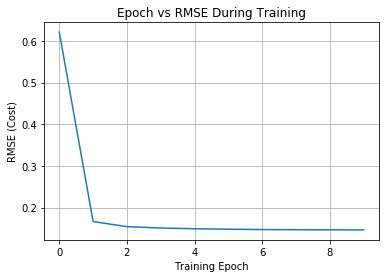

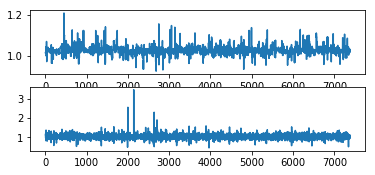

In [7]:
# plt.figure()
plt.plot(np.arange(len(full_costs)), full_costs)
plt.xlabel('Training Epoch')
plt.ylabel('RMSE (Cost)')
plt.grid(True)
plt.title('Epoch vs RMSE During Training')
# print full_costs
plt.figure()
plt.subplot(3,1,1)
plt.plot(test_predictions[:])
plt.subplot(3,1,2)
plt.plot(test_labels[:])
plt.show()

# print test_set[1:5]
# print reversed(test_set[1:5])

In [8]:
organized_predictions = np.array(test_predictions).reshape((len(test_set)/test_on, test_on))
organized_labels = test_labels.reshape((len(test_set)/test_on,test_on)) 
import csv   

def get_returns(num_picks):
    picks = []
    ret_actual = []
    ret_pred = []
    for i in range(test_on):
        picks.append(np.argsort(organized_predictions[:,i])[-num_picks:])
        ret_actual.append(np.average(organized_labels[:,i][picks[i]]))
        ret_pred.append(np.average(organized_predictions[:,i][picks[i]]))
    
    return (picks, ret_actual, ret_pred)

## Testing Returns with Different Number of Stock Selections

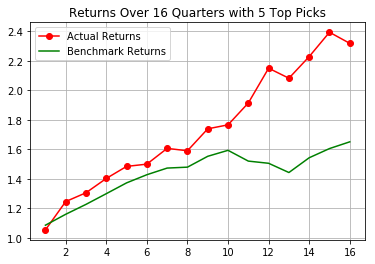

[ 1.05460076  1.24656297  1.30616887  1.40297378  1.48462707  1.49988486
  1.60663167  1.59034773  1.73900832  1.76588251  1.91406231  2.14932048
  2.08150377  2.22803966  2.39276858  2.31758567]
[ 1.08649413  1.16044191  1.22755233  1.29993181  1.37306195  1.42828483
  1.47326058  1.47948093  1.55296059  1.59339159  1.52043452  1.50570843
  1.44311605  1.54316265  1.60529212  1.65095233]


In [9]:
num_picks = 5
picks, ret_actual, ret_pred = get_returns(num_picks)
_, ret_benchmark, _ = get_returns(len(test_set)/test_on)
with open('temp_data.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(np.cumprod(ret_actual))
trange = np.linspace(1,test_on, test_on)
plt.figure()
plt.plot(trange, np.cumprod(ret_actual), 'ro-', label='Actual Returns')
# plt.plot(trange, np.cumprod(ret_pred), 'bo-', label='Predicted Returns')
plt.plot(trange, np.cumprod(ret_benchmark), 'g', label='Benchmark Returns')
plt.title('Returns Over {} Quarters with {} Top Picks'.format(test_on, num_picks))
plt.legend()
plt.grid(True)
plt.show()

print np.cumprod(ret_actual)
print np.cumprod(ret_benchmark)

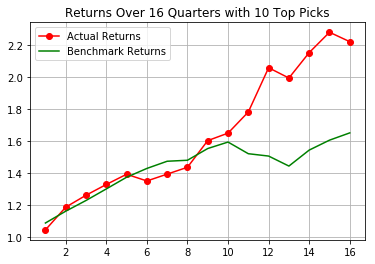

[ 51 265 410 450 457]


In [21]:
num_picks = 10
picks, ret_actual, ret_pred = get_returns(num_picks)
with open('temp_data.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(np.cumprod(ret_actual))
trange = np.linspace(1,test_on, test_on)
plt.figure()
plt.plot(trange, np.cumprod(ret_actual), 'ro-', label='Actual Returns')
# plt.plot(trange, np.cumprod(ret_pred), 'bo-', label='Predicted Returns')
plt.plot(trange, np.cumprod(ret_benchmark), 'g', label='Benchmark Returns')
plt.title('Returns Over {} Quarters with {} Top Picks'.format(test_on, num_picks))
plt.legend()
plt.grid(True)
plt.show()


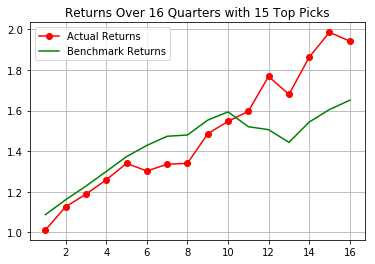

[ 1.0114498   1.12572941  1.1878282   1.25854432  1.33977211  1.3018033
  1.33531356  1.33985088  1.48575825  1.54657729  1.59621455  1.76848787
  1.67924415  1.86320144  1.9861997   1.94215366]


In [11]:
num_picks = 15
picks, ret_actual, ret_pred = get_returns(num_picks)
with open('temp_data.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(np.cumprod(ret_actual))
trange = np.linspace(1,test_on, test_on)
plt.figure()
plt.plot(trange, np.cumprod(ret_actual), 'ro-', label='Actual Returns')
# plt.plot(trange, np.cumprod(ret_pred), 'bo-', label='Predicted Returns')
plt.plot(trange, np.cumprod(ret_benchmark), 'g', label='Benchmark Returns')
plt.title('Returns Over {} Quarters with {} Top Picks'.format(test_on, num_picks))
plt.legend()
plt.grid(True)
plt.show()

print np.cumprod(ret_actual)

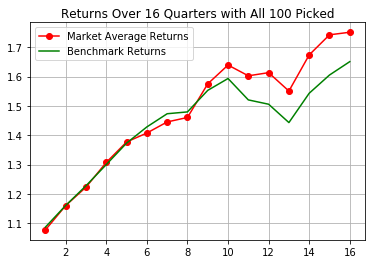

[ 1.07694427  1.16008144  1.22282607  1.30722523  1.37692808  1.40744136
  1.4452433   1.46054283  1.57518232  1.63931066  1.60265485  1.61337798
  1.55066629  1.67394821  1.74245476  1.75123571]


In [12]:
num_picks = 100
picks, ret_actual, ret_pred = get_returns(num_picks)
with open('temp_data.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(np.cumprod(ret_actual))
trange = np.linspace(1,test_on, test_on)
plt.figure()
plt.plot(trange, np.cumprod(ret_actual), 'ro-', label='Market Average Returns')
# plt.plot(trange, np.cumprod(ret_pred), 'bo-', label='Predicted Returns')
plt.plot(trange, np.cumprod(ret_benchmark), 'g', label='Benchmark Returns')
plt.title('Returns Over {} Quarters with All {} Picked'.format(test_on, num_picks))
plt.legend()
plt.grid(True)
plt.show()

print np.cumprod(ret_actual)

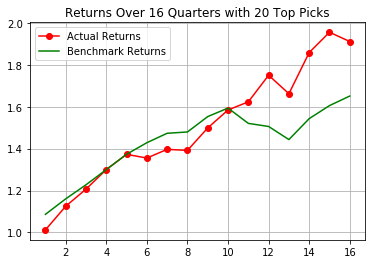

Round 0 has intersects [ 42  51  54  79  91 103 177 196 217 247 249 265 308 347 358 399 410 427
 450 457]
Round 1 has intersects [ 42  51 103 217 249 265 358 399 410 450 457]
Round 2 has intersects [ 42  51 103 265 358 410 450 457]
Round 3 has intersects [103 265 358 410 450 457]
Round 4 has intersects [103 265 358 410 450 457]
Round 5 has intersects [103 265 410 450 457]
Round 6 has intersects [103 265 410 450 457]
Round 7 has intersects [103 410 450 457]
Round 8 has intersects [103 410 450 457]
Round 9 has intersects [103 410 450]
Round 10 has intersects [103 410]
Round 11 has intersects [103 410]
Round 12 has intersects [103 410]
Round 13 has intersects [103 410]
Round 14 has intersects [103 410]
Round 15 has intersects [103 410]


In [22]:
num_picks = 20
picks, ret_actual, ret_pred = get_returns(num_picks)
with open('temp_data.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(np.cumprod(ret_actual))

# print np.cumprod(ret_actual)
intersect = picks[0]
for i in range(test_on):
    intersect = np.intersect1d(intersect, picks[i])
    print("Round {} has intersects {}".format(i, intersect))
    
trange = np.linspace(1,test_on, test_on)
plt.figure()
plt.plot(trange, np.cumprod(ret_actual), 'ro-', label='Actual Returns')
# plt.plot(trange, np.cumprod(ret_pred), 'bo-', label='Predicted Returns')
plt.plot(trange, np.cumprod(ret_benchmark), 'g', label='Benchmark Returns')
plt.title('Returns Over {} Quarters with {} Top Picks'.format(test_on, num_picks))
plt.legend()
plt.grid(True)
plt.show()


In [13]:
print organized_predictions[:5]
# print organized_labels[:50]

[[ 1.01475179  1.01475179  1.01475179  1.01475179  1.01475179  1.01475179
   1.01475179  1.01475179  1.01475179  1.01475179  1.01475179  1.01475179
   1.01475179  1.01475179  1.01475179  1.01475179]
 [ 1.04238069  1.01796639  1.0177896   1.03699684  1.04238069  1.01796639
   1.03699684  1.03699684  0.99800515  1.04238069  1.04238069  1.06927693
   0.99800515  1.04386044  1.00489891  1.00489891]
 [ 0.97113883  1.03518891  1.03518891  1.02685499  1.02685499  1.02685499
   1.02685499  1.02685499  0.99654198  1.0385474   1.00029397  1.00029397
   1.00029397  1.0236131   1.0385474   1.0385474 ]
 [ 1.03037524  1.0390141   1.03037524  1.03037524  1.03037524  1.03037524
   1.03037524  1.03037524  1.03037524  1.03037524  1.03037524  1.03037524
   1.03037524  1.03037524  1.04120314  1.03037524]
 [ 1.01903248  1.01903248  1.01903248  1.01903248  1.01903248  1.01903248
   1.01903248  1.01903248  1.01903248  1.01903248  1.01903248  1.01903248
   1.01903248  1.01903248  1.01903248  1.01903248]]


In [14]:
# from sklearn.neural_network import MLPRegressor 
# from sklearn.tree import DecisionTreeRegressor 
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.neighbors import KNeighborsRegressor
# #create neural net regressor
# print "Starting Fit"
# reg = MLPRegressor(hidden_layer_sizes=(500,500), verbose=True, early_stopping=True,
#                    learning_rate='constant' ,solver="sgd", tol=1e-2,activation='logistic')
# # reg = AdaBoostRegressor()
# reg.fit(train_set,np.ravel(train_labels))
# print "Fit Complete"
# #test prediction
# # test_x=[[x] for x in  range(201,220,2)]
 
# # train_predictions = reg.predict(train_set)

# # print "Loss: {}".format(np.sqrt(np.mean(np.square(train_predictions - train_labels))))
# test_predictions=reg.predict(test_set)
# print "Prediction Complete"
# print test_predictions.shape

# # plt.figure()
# # plt.subplot(2,1,1)
# # plt.plot(predict[:150])
# # plt.subplot(2,1,2)
# # plt.plot(test_labels[:150])
# # plt.show()